**This notebook serves the purpose of clustering authors based on the ti-idf vector representations of their papers' abstract.**

**Resources consulted online**:
1. https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
2. https://stackoverflow.com/questions/15197673/using-pythons-eval-vs-ast-literal-eval
3. https://stackoverflow.com/questions/4530611/saving-and-loading-objects-and-using-pickle

# Load modules

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
from wordcloud import WordCloud

In [2]:
# Ignore warning messages (only) for display purpose
import warnings
warnings.filterwarnings('ignore')

# Prepare the dataset used for clustering

In [ ]:
df = pd.read_csv('../database/preprocessed_content_analysis.csv', index_col=0)
df

In [44]:
# prepare data for clustering
df['normalized_abstract'] = df['normalized_abstract'].apply(ast.literal_eval)
#df['normalized_abstract'] = df['normalized_abstract'].apply(lambda x: [item for sublist in x for item in sublist])
df['normalized_abstract'] = df['normalized_abstract'].apply(lambda x: ' '.join(x))

In [46]:
# group by email and concatenate abstracts
cluster_df = df.groupby('email')['normalized_abstract'].apply(lambda x: '. '.join(x)).reset_index()

# Perform clustering

In [47]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# generate a sparse TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_df['normalized_abstract'])

# convert the sparse TF-IDF matrix to a dense matrix
tfidf_matrix = tfidf_matrix.toarray()

In [48]:
# fit SVD
n_components = min(tfidf_matrix.shape) - 1
pca = PCA(n_components=n_components)
pca.fit(tfidf_matrix)

# calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# calculate the number of SVD components capturing 95% variance 
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
num_components

1417

In [49]:
# fit and transform TF-IDF matrix
pca = PCA(n_components=1417, random_state=42)
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix)

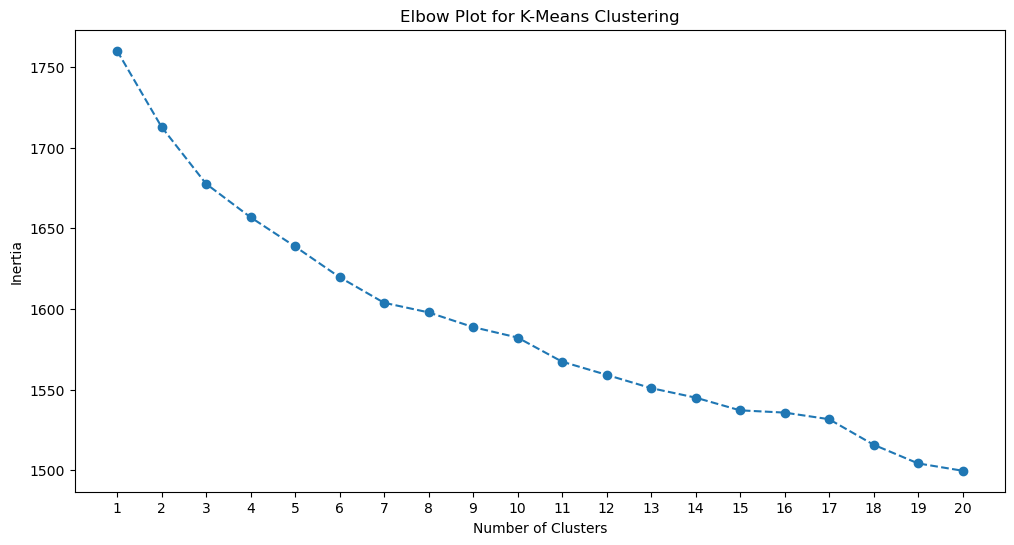

In [50]:
# calculate the inertia for each number of clusters
num_clusters = range(1, 21)
inertias = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix_reduced)
    inertias.append(kmeans.inertia_)

# plot the elbow plot
plt.figure(figsize=(12, 6))
plt.plot(num_clusters, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means Clustering')
plt.xticks(num_clusters)
plt.show()

In [51]:
# perform K-means clustering on the reduced TF-IDF matrix
kmeans_tfidf = KMeans(n_clusters=7, random_state=42)
kmeans_tfidf.fit(tfidf_matrix_reduced)

# add cluster labels to the dataframe
cluster_df['tfidf_cluster'] = kmeans_tfidf.labels_

In [54]:
# function to find the most distinctive words in each cluster
def find_distinctive_words_by_cluster(clusters, n=20):
    aggregate_tfidf_vectors_by_cluster = {}
    
    for i, cluster in enumerate(clusters):
        if cluster not in aggregate_tfidf_vectors_by_cluster:
            aggregate_tfidf_vectors_by_cluster[cluster] = tfidf_matrix[i]
        else:
            aggregate_tfidf_vectors_by_cluster[cluster] += tfidf_matrix[i]

    distinctive_words_by_cluster = {}
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    for cluster, agg_tfidf in aggregate_tfidf_vectors_by_cluster.items():
        sorted_indices = np.argsort(agg_tfidf).flatten()[::-1]
        distinctive_words_by_cluster[cluster] = feature_names[sorted_indices][:n]
    
    return distinctive_words_by_cluster

In [55]:
# find 20 most distinctive words in each cluster
find_distinctive_words_by_cluster(cluster_df['tfidf_cluster'])

{1: array(['language', 'word', 'linguistic', 'speaker', 'speech', 'english',
        'child', 'sentence', 'verb', 'vowel', 'syntactic', 'study',
        'semantic', 'listener', 'l2', 'lexical', 'phonological', 'grammar',
        'bilingual', 'experiment'], dtype=object),
 3: array(['visual', 'memory', 'task', 'brain', 'neural', 'stimulus',
        'object', 'study', 'model', 'participant', 'cortex', 'cognitive',
        'response', 'experiment', 'human', 'network', 'information',
        'control', 'learn', 'processing'], dtype=object),
 4: array(['child', 'study', 'social', 'self', 'emotion', 'participant',
        'research', 'behavior', 'infant', 'people', 'woman', 'group',
        'individual', 'health', 'adolescent', 'effect', 'examine',
        'experience', 'racial', 'result'], dtype=object),
 5: array(['primate', 'human', 'specie', 'genetic', 'fossil', 'population',
        'study', 'gene', 'chimpanzee', 'bone', 'male', 'variation',
        'hominin', 'evolution', 'evolutionary

In [56]:
# create a cluster mapping
tfidf_cluster_mapping = {
    0: 'Cultural Studies',
    1: 'Linguistics',
    2: 'Environmental Studies',
    3: 'Neuroscience',
    4: 'Psychology',
    5: 'Human Biology',
    6: 'Archaeology'
}

# apply the mapping to TF-IDF clusters
cluster_df['tfidf_cluster'] = cluster_df['tfidf_cluster'].map(tfidf_cluster_mapping)

In [57]:
# initiate a TF-IDF vectorizer 
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# generate TF-IDF matrix in sparse format
tfidf_matrix_sparse = tfidf_vectorizer.fit_transform(cluster_df['normalized_abstract'])

# convert the sparse TF-IDF matrix to a dense matrix
tfidf_matrix_dense = tfidf_matrix_sparse.toarray()

# reduce the TF-IDF matrix to 2 dimensions using PCA
pca = PCA(n_components=2, random_state=42)
tfidf_matrix_2D = pca.fit_transform(tfidf_matrix_dense)

# apply k-means clustering on the reduced data
kmeans_tfidf = KMeans(n_clusters=9, random_state=42)
kmeans_tfidf.fit(tfidf_matrix_2D)

KMeans(n_clusters=9, random_state=42)

In [58]:
# Save `cluster_df` for later descriptive and visualization
cluster_df.to_csv("../database/author_clustering/cluster_df.csv", index=False)

In [59]:
# Save `tfidf_matrix_2D`, `tfidf_cluster_mapping`, and `kmeans_tfidf` for later descriptive and visualization
with open('../database/author_clustering/tfidf_matrix_2D.pkl', 'wb') as file:
    pickle.dump(tfidf_matrix_2D, file)

with open('../database/author_clustering/tfidf_cluster_mapping.pkl', 'wb') as file:
    pickle.dump(tfidf_cluster_mapping, file)

with open('../database/author_clustering/kmeans_tfidf.pkl', 'wb') as file:
    pickle.dump(kmeans_tfidf, file)